<a href="https://colab.research.google.com/github/dalatorrem/Diplomado_Metodos_UCentral_2023/blob/main/Lectura_26_Linear_Regression_Part_IV_stud_mod_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

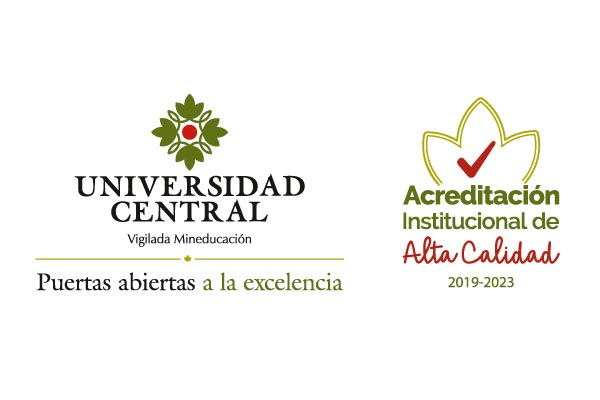

---

# ***¿Cuánto deberían costar las propiedades en Milwaukee, Wisconsin? (Parte II)***

---

---

## ***Objetivos***

---

En los últimos casos, hemos visto varias técnicas utilizadas para diagnosticar la aplicabilidad de los modelos de regresión lineal. Hemos aprendido cómo usar indicadores como el **AIC** para comparar y detectar modelos demasiado complicados, cómo un estudio adecuado de los residuos puede ayudar a ajustar mejor nuestros modelos y cómo ampliar la aplicabilidad de los modelos lineales con el uso de transformaciones de variables. El objetivo de esta lectura es aprender un par de herramientas que nos ayudarán a comprender mejor la aplicabilidad de nuestros modelos:

1. El uso de conjuntos de `test/train` (prueba/entrenamiento) para evaluar el rendimiento de modelos.
2. Detección de **multicolinealidad** para mejorar la estabilidad numérica y aumentar la robustez del modelo predictivo.



***NUNCA VER TEST DURANTE LA ETAPA DE ENTRENAMIENTO DEL MODELO***

---

## ***Introducción.***

---

**Contexto empresarial.** Continuamos en el contexto de la parte I (promotor inmobiliario), con el mismo objetivo. El modelo anterior que creó fue un buen comienzo, no incorporó todas las variables que deseaba incluir, y es escéptico sobre qué tan bien podría funcionar con datos en los que no fue entrenado; es decir, **datos fuera de la muestra**.

**Problema comercial.** Su tarea es **mejorar su modelo para predecir los precios de las propiedades en la ciudad de Milwaukee, Wisconsin**.

**Contexto analítico.** Nuevamente, el conjunto de datos consta de ventas de propiedades residenciales en Milwaukee, Wisconsin, de 2002 a 2018. Se centró en diagnosticar y solucionar posibles problemas que surgen en la regresión lineal. En la lectura anterior, aprendimos cómo analizar visualmente los residuos y detectar valores atípicos y heterocedasticidad. Mostramos que la transformación de variables puede mejorar algunos de estos problemas, mientras que la eliminación explícita de valores atípicos *explicables por factores externos* podría mejorar las cosas aún más.

La lectura está estructurada de la siguiente manera:

1. Se aprenderá cómo se manejan realmente las variables categóricas en los modelos de regresión.

2. Se profundizará en la capacidad predictiva del modelo y aprender a evaluarlo y mejorarlo.

3. Analizar la **multicolinealidad**, un problema que surge cuando se ajustan modelos de regresión con predictores altamente correlacionados o demasiados, y cómo abordarlo.

---

## ***Preparando nuestra data.***

---

Retomaremos donde dejamos las cosas al final de la última lectura, la única diferencia es que eliminaremos del conjunto de datos todas las propiedades con un precio de venta por debajo de $2,000, que pueden no corresponder a precios reales de mercado, según nuestro análisis de residuales en el último ejercicio de la lectura.

In [1]:
import pandas                   as pd
import numpy                    as np
import matplotlib.pyplot        as plt
import seaborn                  as sns
from   scipy                    import stats
import statsmodels.formula.api  as smf
import scipy
import warnings
from sklearn.model_selection    import train_test_split
from sklearn.linear_model       import LinearRegression
from sklearn.metrics            import mean_squared_error, mean_absolute_error
from sklearn.metrics            import mean_absolute_percentage_error
##
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15,6)
warnings.filterwarnings('ignore')
url_base = 'https://raw.githubusercontent.com/lacamposm/Fundamentos_Analitica/main/data/'

In [2]:
data = pd.read_csv(url_base + 'prueba_MLR.csv',
                   dtype={'District': 'category',
                          'Extwall': 'category',
                          'Nbhd': 'category',
                          'Style': 'category',
                          },)
clean = np.where((data['Sale_price'] > 2000) & # Según la lectura anterior.
                 (data['Year_Built'] > 1800) &
                 (data['Fin_sqft'] > 0) &      # Se debe tener pies cuadrados terminados mayores a cero.
                 (data['Lotsize'] > 0)         # Se debe tener un tamaño de lote mayor que 0.
                 )
data_clean = data.iloc[clean].copy()
print('Tamaño del set de datos SIN eliminación duplicados:', data_clean.shape)
data_clean = data_clean.drop_duplicates()
print('Tamaño del set de datos CON eliminación duplicados:', data_clean.shape)

Tamaño del set de datos SIN eliminación duplicados: (24445, 19)
Tamaño del set de datos CON eliminación duplicados: (24411, 19)


In [3]:
data_clean.drop(columns=['CondoProject', 'PropType', 'Taxkey', 'Address'], inplace=True)
data_clean.shape

(24411, 15)

---

## ***Conjuntos: Training vs. test.***

---

Una de las principales preocupaciones es si el modelo que hemos construido funciona tan bien con datos fuera de la muestra como con datos dentro de la muestra. Este es un problema *muy* común en la construcción de modelos, conocido como **overfitting**.

La idea es dividir aleatoriamente los datos en un conjunto de entrenamiento (`Training`) y un conjunto de prueba (`Test`). El **`training set`** es el usado para entrenar y ajustar el modelo de regresión lineal múltiple. Luego debemos ver que sucede con el modelo ajustado en el **`test set`** y comparamos sus predicciones con los datos de la variable de respuesta del `test set` para evaluar su rendimiento.



### ***Ejemplo 1:***

---

Vamos a escribir un código para dividir los datos test y train (una división 80-20 es un buen punto de partida). Seguido vamos a ajustar un modelo de regresión lineal en el conjunto `train` tomando el logaritmo de `Sale_price` como variable de respuesta, `District`, `Units` y el logaritmo de `Fin_sqft` como variables predictoras.'

***Respuesta.***

---

Establecemos en `train_test_split` una *semilla aleatoria* con `random_state=123`, lo que garantiza que al ejecutar esta celda se obtengan los mismos números aleatorios y, por lo tanto, los mismos resultados en el análisis posterior. Luego elegimos el tamaño del set de test con `test_size=0.2` lo que equivale a que el $80\%$ de los datos estarán en el set de train.

In [4]:
X_train, X_test = train_test_split(data_clean, test_size=0.2, random_state=123)

In [5]:
print(f'Tamaño set de train: {X_train.shape}')
print(f'Tamaño set de test:  {X_test.shape}')

Tamaño set de train: (19528, 15)
Tamaño set de test:  (4883, 15)


In [6]:
model_log = smf.ols(formula='np.log(Sale_price)~C(District)+Units+np.log(Fin_sqft)',data=X_train).fit()
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     1912.
Date:                Fri, 25 Aug 2023   Prob (F-statistic):               0.00
Time:                        02:44:22   Log-Likelihood:                -7498.4
No. Observations:               19528   AIC:                         1.503e+04
Df Residuals:                   19511   BIC:                         1.516e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.2277      0.06

---

### ***Variables categóricas debajo del modelo***

---

Debe notar que hay una docena de coeficientes para `District` arriba. Esto se debe a que es una variable categórica y, para las variables categóricas, se obtiene un coeficiente para todas las categorías menos una. Si solo hay dos categorías (por ejemplo, género), la característica se convierte en una columna de ceros y unos antes de introducirla en la regresión, donde se trata como una variable numérica regular.

Cuando hay más de dos categorías, una categoría se designa como la categoría de "referencia" o "línea de base", y se crean columnas `dummy` de unos y ceros para todas las demás categorías. Tomemos un ejemplo ficticio con tres categorías y cinco registros:

| Categorica   |
|--------------|
| A            |
| B            |
| C            |
| C            |
| A            |

Antes de ajustar la regresión lineal, la columna `Categorica` se transforma en **dos** columnas `dummys` (no se agrega una columna para la categoría de referencia).

La primera columna es 1 si es `B` y 0 en caso contrario, mientras que la segunda columna es 1 si el distrito es `C` y 0 en caso contrario. Obtenemos:

| Categorica_B | Categorica_C |
|--------------|------------- |
| 0            | 0            |
| 1            | 0            |
| 0            | 1            |
| 0            | 1            |
| 0            | 0            |

Las columnas `dummys` se introducen en la regresión lineal y se tratan como variables numéricas regulares. Esta técnica se llama **one-hot encoding** y se puede hacer manualmente con el método de `pandas`, `pd.get_dummies()`:




In [7]:
## Ejemplo dummyzar una variable categórica.
df_dummy=pd.DataFrame({'Category':['A','B','C','C','A']})
pd.get_dummies(df_dummy,columns=['Category'], drop_first=True) # drop_first = True, elimina la
                                                               # la primera categoría

,Category_B,Category_C
0,0,0
1,1,0
2,0,1
3,0,1
4,0,0


In [8]:
## Acá no eliminamos la primera categoría.
pd.get_dummies(df_dummy,columns=['Category'])

,Category_A,Category_B,Category_C
0,1,0,0
1,0,1,0
2,0,0,1
3,0,0,1
4,1,0,0


In [9]:
## COMENTARIO <---- OJO. LinearRegression con sklear.linear_model
df_ml = data_clean.copy()
X = df_ml.drop(columns=['Sale_price'])  ## Variables explicativas (independientes).
y = df_ml['Sale_price']                 ## Variable target (dependiente).
##
X_train_sk, X_test_sk, y_train_sk, y_test_sk = train_test_split(X,y, test_size=0.2, random_state=123)
model_log_sk = LinearRegression()
## Prepocesamiento en el set de Train.
X_train_sk['log_Fin_sqft'] = np.log(X_train_sk['Fin_sqft'])
X_train_sk_ex = X_train_sk[['District', 'Units', 'log_Fin_sqft']]
X_train_sk_ex = pd.get_dummies(X_train_sk_ex,drop_first=True)
## Entrenamos el modelo
model_log_sk.fit(X_train_sk_ex,np.log(y_train_sk))
##
print('R^2 = {:.4f}'.format(model_log_sk.score(X_train_sk_ex,np.log(y_train_sk))))

R^2 = 0.6106


In [10]:
model_log_sk.score

<bound method RegressorMixin.score of LinearRegression()>

### ***Ejemplo 2.***

---


#### ***2.1***

Agregue la variable `Style` al último modelo de regresión. Haga esto de dos maneras: primero transformando la variable `Style` usando `pd.get_dummies()` y luego sin la transformación. Compruebe que se obtiene los mismos resultados. Según este modelo, ¿qué `Style` de propiedad es el más deseable?

**Hint:** La variable `Style` contiene nombres como `Residence O/S`, que pueden ser problemáticos al escribir fórmulas `smf.ols`(vea la [Pasty Syntax](https://patsy.readthedocs.io/en/latest/index.html)). Puede usar la sintaxis `Pasty` entre comillas `Q()` en nombres de variables para evitar este problema:

```
formula="np.log(Precio_de_venta) ~Q("Residencia O/S")+...
```




***Respuesta.***

---


In [11]:
X_train['Style'].unique()

['Ranch', 'Residence O/S', 'Duplex O/S', 'Cape Cod', 'Duplex N/S', ..., 'Split Level', 'AP 1', 'Bi-Level', 'Mansion', 'Rm or Rooming House']
Length: 18
Categories (18, object): ['AP 1', 'Bi-Level', 'Cape Cod', 'Colonial', ..., 'Split Level',
                          'Townhouse', 'Triplex', 'Tudor']

In [12]:
pd.get_dummies

<function pandas.core.reshape.encoding.get_dummies(data, prefix=None, prefix_sep='_', dummy_na: 'bool' = False, columns=None, sparse: 'bool' = False, drop_first: 'bool' = False, dtype: 'Dtype | None' = None) -> 'DataFrame'>

In [13]:
Styles = list(X_train['Style'].unique())    ## Valores únicos en una lista.
Styles.sort()                               ## Lista ordenada.
X_train_dummy = pd.get_dummies(X_train, columns = ['Style'], prefix ='', prefix_sep ='', drop_first=True)
X_train_dummy.columns

Index(['District', 'Nbhd', 'Extwall', 'Stories', 'Year_Built', 'Nr_of_rms',
       'Fin_sqft', 'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'Sale_price',
       'Sale_year', 'Bi-Level', 'Cape Cod', 'Colonial', 'Cottage',
       'Dplx Bungalow', 'Duplex N/S', 'Duplex O/S', 'Duplex-Cottage',
       'Mansion', 'Milwaukee Bungalow', 'Ranch', 'Residence O/S',
       'Rm or Rooming House', 'Split Level', 'Townhouse', 'Triplex', 'Tudor'],
      dtype='object')

In [14]:
# Escribimos la fórmula de regresión de la variables categóricas y sin la categoría de referencia.
formula0 = "np.log(Sale_price) ~ "
for style in Styles[1:]:
    formula0+='Q("'+style+'")+'
print(formula0)

np.log(Sale_price) ~ Q("Bi-Level")+Q("Cape Cod")+Q("Colonial")+Q("Cottage")+Q("Dplx Bungalow")+Q("Duplex N/S")+Q("Duplex O/S")+Q("Duplex-Cottage")+Q("Mansion")+Q("Milwaukee Bungalow")+Q("Ranch")+Q("Residence O/S")+Q("Rm or Rooming House")+Q("Split Level")+Q("Townhouse")+Q("Triplex")+Q("Tudor")+


In [15]:
## Finalmente la formula de regresión.
formula0 = formula0 + 'C(District) + Units+ np.log(Fin_sqft)'
print(formula0)

np.log(Sale_price) ~ Q("Bi-Level")+Q("Cape Cod")+Q("Colonial")+Q("Cottage")+Q("Dplx Bungalow")+Q("Duplex N/S")+Q("Duplex O/S")+Q("Duplex-Cottage")+Q("Mansion")+Q("Milwaukee Bungalow")+Q("Ranch")+Q("Residence O/S")+Q("Rm or Rooming House")+Q("Split Level")+Q("Townhouse")+Q("Triplex")+Q("Tudor")+C(District) + Units+ np.log(Fin_sqft)


In [16]:
# Creamos el modelo.
model_style_1 = smf.ols(formula=formula0, data=X_train_dummy).fit()
print(model_style_1.summary())

                            OLS Regression Results                            
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     1048.
Date:                Fri, 25 Aug 2023   Prob (F-statistic):               0.00
Time:                        02:44:22   Log-Likelihood:                -6743.0
No. Observations:               19528   AIC:                         1.355e+04
Df Residuals:                   19494   BIC:                         1.382e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [17]:
## Modelo sin 'one-hot-encoding'
model_style = smf.ols(formula='np.log(Sale_price) ~ Style + C(District) + Units+ np.log(Fin_sqft)', data=X_train).fit()
print(model_style.summary())

                            OLS Regression Results                            
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     1048.
Date:                Fri, 25 Aug 2023   Prob (F-statistic):               0.00
Time:                        02:44:23   Log-Likelihood:                -6743.0
No. Observations:               19528   AIC:                         1.355e+04
Df Residuals:                   19494   BIC:                         1.382e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

El `Style` `Mansion` es el más deseable según este modelo, ya que tiene el coeficiente positivo más alto.



#### ***2.2***

En el modelo a continuación, ***no*** eliminamos la categoría de referencia después de usar `get_dummies()`. ¿Es correcto este modelo? ¿Por qué si o por qué no?




In [18]:
train_dummy2 = pd.get_dummies(X_train, columns=['Style'],prefix='',prefix_sep='',)
train_dummy2

,District,Nbhd,Extwall,Stories,Year_Built,Nr_of_rms,Fin_sqft,Units,Bdrms,Fbath,...,Duplex-Cottage,Mansion,Milwaukee Bungalow,Ranch,Residence O/S,Rm or Rooming House,Split Level,Townhouse,Triplex,Tudor
21204,5,2100,Aluminum / Vinyl,1.0,1952,0,645,1,2,1,...,0,0,0,1,0,0,0,0,0,0
24113,13,4660,Aluminum / Vinyl,1.0,1965,0,1423,1,3,1,...,0,0,0,1,0,0,0,0,0,0
14928,14,4520,Brick,1.0,1929,0,1688,1,3,1,...,0,0,0,0,1,0,0,0,0,0
22737,15,2380,Aluminum / Vinyl,2.0,1914,0,2100,2,4,2,...,0,0,0,0,0,0,0,0,0,0
14850,13,4700,Aluminum / Vinyl,1.0,1941,0,1233,1,3,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15410,6,2860,Aluminum / Vinyl,1.5,1895,0,1538,1,4,2,...,0,0,0,0,1,0,0,0,0,0
21641,7,1830,Stone,2.0,1950,0,2122,2,4,2,...,0,0,0,0,0,0,0,0,0,0
17765,8,4120,Aluminum / Vinyl,1.0,1905,0,1509,2,4,2,...,1,0,0,0,0,0,0,0,0,0
15758,5,2120,Frame,1.0,1988,0,1776,1,3,2,...,0,0,0,1,0,0,0,0,0,0


In [19]:
train_dummy2 = pd.get_dummies(X_train, columns=['Style'],prefix='',prefix_sep='')
formula1 = "np.log(Sale_price) ~ "
for style in Styles:
    formula1 += 'Q("'+style+'")+'
formula1 = formula1 + 'C(District) + Units+ np.log(Fin_sqft)'
## Creamos el modelo.
model_style_2 = smf.ols(formula=formula1, data = train_dummy2).fit()
print(model_style_2.summary())

                            OLS Regression Results                            
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     1048.
Date:                Fri, 25 Aug 2023   Prob (F-statistic):               0.00
Time:                        02:44:23   Log-Likelihood:                -6743.0
No. Observations:               19528   AIC:                         1.355e+04
Df Residuals:                   19494   BIC:                         1.382e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

***Respuesta.***

---

Veamos las diferencias entre los coeficientes de los dos modelos:

In [20]:
df_coeff = pd.merge(model_style_1.params.reset_index(),model_style_2.params.reset_index(),
                    on = 'index', how = 'outer')
df_coeff = df_coeff.rename(columns={'index':'Coeficiente','0_x':'Sin_referencia', '0_y':'Con_referencia'})
df_coeff['Error'] = df_coeff['Sin_referencia'] - df_coeff['Con_referencia']
df_coeff

,Coeficiente,Sin_referencia,Con_referencia,Error
0,Intercept,4.457751,4.191478,2.662724e-01
1,C(District)[T.10],0.671778,0.671778,1.665335e-15
2,C(District)[T.11],0.775663,0.775663,-6.661338e-16
3,C(District)[T.12],0.161252,0.161252,1.443290e-15
4,C(District)[T.13],0.766535,0.766535,3.330669e-16
5,C(District)[T.14],0.955035,0.955035,-2.886580e-15
6,C(District)[T.15],-0.377361,-0.377361,9.992007e-16
7,C(District)[T.2],0.264970,0.264970,-2.664535e-15
8,C(District)[T.3],1.119370,1.119370,4.440892e-16
9,C(District)[T.4],-0.165698,-0.165698,2.275957e-15


Los coeficientes de `model_style_1` se obtienen esencialmente a partir de los coeficientes de `model_style_2` después de restar 0.266272, (el coeficiente de la categoría base `Q("AP 1")`) al resto de coeficientes correspondientes a la variable `Style`, es decir, son esencialmente iguales.

Sin embargo, incorporar la categoría de referencia en el modelo agrega redundancia: si conocemos los valores de todas las variables `dummys` de `Style` excepto `Q("AP 1")`, sabemos el valor de la variable `dummy` que corresponde a `Q("AP 1")`. Estas redundancias a menudo crean problemas numéricos, lo que puede hacer que nuestros modelos se comporten mal (observe que la segunda advertencia en este último resumen que no apareció en los anteriores). Este es un ejemplo de **multicolinealidad**, más adelante lo discutiremos.




---

## ***Evaluación del rendimiento predictivo***

---

Para cualquier conjunto de datos dado, el residuo es la diferencia entre la predicción del modelo para ese registro y el valor real de ese punto. El **error absoluto medio (MAE)** es una métrica que resume el rendimiento holístico (del todo) del modelo en toda la data. El MAE se calcula tomando el valor absoluto de cada residuo y luego tomando la media de todos esos valores absolutos. En esencia, el MAE describe la magnitud típica de los residuales; cuanto menor sea el MAE, mejor.

In [21]:
model_log

In [22]:
## Función que calcula el MAE (Mean Absolute Error) de un modelo.
def MAE(true_values, prediction):
    '''
    Input: true_values : Valores de la varible respuesta en el conjunto X.
           prediction : Valores ajustados del modelo en el conjunto X.
    Output: MAE (Error absoluto medio) del modelo sobre el conjunto X.
    '''
    return np.mean(np.abs(true_values-prediction))
##
MAE_model_log_train = MAE(model_log.predict(X_train), np.log(X_train['Sale_price']))
MAE_model_log_test = MAE(model_log.predict(X_test), np.log(X_test['Sale_price']))
##
MAE_exp_modelo_log_train = MAE(np.exp(model_log.predict(X_train)) ,X_train['Sale_price'])
MAE_exp_modelo_log_test = MAE(np.exp(model_log.predict(X_test)) ,X_test['Sale_price'])
##
print('MAE model_log y log de los verdaderos valores de Sale price en TRAIN:',MAE_model_log_train)
print('MAE model_log y log de los verdaderos valores de Sale price en TEST: ',MAE_model_log_test)
print('-'*90)
print('MAE exp(model_log) y los verdaderos valores de Sale price en TRAIN:',MAE_exp_modelo_log_train)
print('MAE exp(model_log) y los verdaderos valores de Sale price en TEST:',MAE_exp_modelo_log_test)

MAE model_log y log de los verdaderos valores de Sale price en TRAIN: 0.24899841350930652
MAE model_log y log de los verdaderos valores de Sale price en TEST:  0.25786917439140145
------------------------------------------------------------------------------------------
MAE exp(model_log) y los verdaderos valores de Sale price en TRAIN: 29927.192121502623
MAE exp(model_log) y los verdaderos valores de Sale price en TEST: 31324.029959167085


Otra opción muy utilizada para evaluar la regresión es  **la raíz del error cuadrático medio (RMSE)**. Esto se calcula tomando el cuadrado de cada residuo, promediando y luego sacando la raíz cuadrada. A continuación se muestra la implementación en python, que posiblemente sea más fácil de entender que la explicación anterior:

In [23]:
## Función que calcula el RMSE (Root Mean Squared Error) de un modelo.
def RMSE(true_values,prediction):
    '''
    Input: true_values : Valores de la varible respuesta en el conjunto X.
           prediction : Valores ajustados del modelo en el conjunto X.
    Output: RMSE (raíz del error medio cuadrático) del modelo sobre el conjunto X.
    '''
    return np.sqrt(np.mean(np.square(true_values-prediction)))
##
RMSE_exp_model_log_train = RMSE(X_train['Sale_price'], np.exp(model_log.predict(X_train)))
RMSE_exp_model_log_test = RMSE(X_test['Sale_price'], np.exp(model_log.predict(X_test)))
##
print('RMSE exp(model_log) y Sale_price en TRAIN:',RMSE_exp_model_log_train)
print('RMSE exp(model_log) y Sale_price en TEST:',RMSE_exp_model_log_test)

RMSE exp(model_log) y Sale_price en TRAIN: 46340.941185600655
RMSE exp(model_log) y Sale_price en TEST: 47516.837822928406


In [24]:
100*np.abs(RMSE_exp_model_log_train-RMSE_exp_model_log_test)/RMSE_exp_model_log_train

2.5374897601197897

**AL evaluar la diferencia entre las métricas considere las diferencias porcentuales y tome como signos de alerta diferencias porcentuales por encima del 10%**

Finalmente, está el **error porcentual absoluto medio**. Esto toma el valor absoluto de cada residual y lo divide por el valor real de ese punto para obtener un porcentaje, luego promediando todos los porcentajes.



**El mape castigo mucho la sobrestimación cuando los valores reales son bajos**

In [25]:
#y_real.mean()

**La media es el valor que minimiza el error cuadrático medio o RMSE** <br>
**La mediana es el valor que minimiza el error absoluto medio o MAE**

In [26]:
y_real = np.array([11, 11])
y_pred = np.array([6,6])
#MAPE(y_real, y_pred)

In [27]:
RMSE(y_pred, y_real), RMSE(y_real, y_pred)

(5.0, 5.0)

OJO EN EL MAPE el orden no importa en RMSE y en MAE el orden no importa en la métrica

In [28]:
## Función que calcula el MAPE (Mean Adsolute Error Percentage) de un modelo.
def MAPE(true_value, prediction):
    return np.mean(np.abs((true_value-prediction)/true_value)*100)
##
MAPE_exp_modelo_log_train = MAPE(X_train['Sale_price'], np.exp(model_log.predict(X_train)))
MAPE_exp_modelo_log_test = MAPE(X_test['Sale_price'], np.exp(model_log.predict(X_test)))
##
print('MAPE entre model_log y log de los verdaderos valores de Sale_price:', MAPE_exp_modelo_log_train)
print('-'*90)
print('MAPE entre exp(model_log) y los verdaderos valores de Sale_price:  ', MAPE_exp_modelo_log_test)

MAPE entre model_log y log de los verdaderos valores de Sale_price: 28.452763979926996
------------------------------------------------------------------------------------------
MAPE entre exp(model_log) y los verdaderos valores de Sale_price:   29.40055311870577


### ***Pregunta:***

---

¿Por qué no usar simplemente MAE en lugar de tener que lidiar con tres métricas diferentes?



Aunque `RMSE` puede parecer innecesariamente complicado en comparación con MAE, se usa mucho más comúnmente. La razón es que la métrica `RMSE` es la misma que se minimiza en el set de train mediante un modelo de regresión lineal estándar (también llamado regresión de **mínimos cuadrados ordinarios (OLS)**). Esto lo convierte en una opción "natural" que utiliza la misma métrica para evaluar el rendimiento fuera de la muestra (`test`). Considere lo siguiente:

1. El `RMSE` pone mucho más peso en los valores atípicos, ya que los errores se elevan al cuadrado antes de promediarlos. En los casos en que los valores atípicos son especialmente malos y deben castigarse, el `RMSE` es una mejor opción.

2. El `MAPE` tiene una buena interpretación en la que podemos decir que las predicciones de un modelo son, en promedio, incorrectas en un cierto porcentaje. Por ejemplo, nuestro modelo de precio de la vivienda podría tener un promedio de descuento del 30%. Dicho modelo a menudo se describe como "70% preciso".

Las siguientes ecuaciones definen las tres métricas de error anteriores:

\begin{eqnarray*}
    MAE &= \frac{1}{n} \sum_{i=1}^n \left| y_i - \hat{y}_i \right| \\
    RMSE &= \sqrt{ \frac{1}{n} \sum_{i=1}^n ( y_i - \hat{y}_i )^2 } \\
    MAPE &= 100\% \frac{1}{n} \sum_{i=1}^n \left|\frac{ y_i - \hat{y}_i}{y_i} \right|
\end{eqnarray*}

In [29]:
## con sklearn.metrics
## 1.MAE
mae_train = mean_absolute_error(np.exp(model_log.predict(X_train)),X_train['Sale_price'],)
mae_test = mean_absolute_error(np.exp(model_log.predict(X_test)),X_test['Sale_price'])
print('='*30)
print(f'MAE en TRAIN: {mae_train:.3f}')
print(f'MAE en TEST:  {mae_test:.3f}')
print('='*30)
## 2.RMSE
mse_train = mean_squared_error(np.exp(model_log.predict(X_train)),X_train['Sale_price'],squared=False)
mse_test = mean_squared_error(np.exp(model_log.predict(X_test)),X_test['Sale_price'], squared=False)
print(f'RMSE en TRAIN: {mse_train:.3f}')
print(f'RMSE en TEST:  {mse_test:.3f}')
print('='*30)
## 3. MAPE
mape_train = mean_absolute_percentage_error(X_train['Sale_price'], np.exp(model_log.predict(X_train)))
mape_test = mean_absolute_percentage_error(X_test['Sale_price'],np.exp(model_log.predict(X_test)))
print(f'MAPE en TRAIN: {mape_train*100:.3f}')
print(f'MAPE en TEST:  {mape_test*100:.3f}')
print('='*30)

MAE en TRAIN: 29927.192
MAE en TEST:  31324.030
RMSE en TRAIN: 46340.941
RMSE en TEST:  47516.838
MAPE en TRAIN: 28.453
MAPE en TEST:  29.401


### ***Ejercicio 1.***

---

#### **3.1**

Calcule el `MAE`, `RMSE` y `MAPE` para el modelo lineal
```
"Sale_price ~ District + Units+ Fin_sqft"
```
¿Cómo se compara este modelo con `model_log`?

***Respuesta.***

---


In [30]:
## Ajustamos el modelo.
model_lin = smf.ols(formula='Sale_price ~ District + Units+ Fin_sqft', data=X_train).fit()

In [31]:
MAE_model_lin = MAE(X_test['Sale_price'], model_lin.predict(X_test))
MAE_model_log = MAE(X_test['Sale_price'], np.exp(model_log.predict(X_test)))
print('MAE entre las predicciones de model_lin y los verdaderos valores de Sale_price:', MAE_model_lin)
print('MAE entre exp(model_log) y los verdaderos valores de Sale_price:               ', MAE_model_log)

MAE entre las predicciones de model_lin y los verdaderos valores de Sale_price: 33279.71366167739
MAE entre exp(model_log) y los verdaderos valores de Sale_price:                31324.029959167085


In [32]:
RMSE_model_lin = RMSE(X_test['Sale_price'], model_lin.predict(X_test))
RMSE_model_log = RMSE(X_test['Sale_price'],np.exp(model_log.predict(X_test)))
print('RMSE entre las predicciones de model_lin y los verdaderos valores de Sale_price:', RMSE_model_lin)
print('RMSE entre exp(model_log) y los verdaderos valores de Sale_price:               ', RMSE_model_log)

RMSE entre las predicciones de model_lin y los verdaderos valores de Sale_price: 49779.99980711587
RMSE entre exp(model_log) y los verdaderos valores de Sale_price:                47516.837822928406


In [33]:
MAPE_model_lin = MAPE(X_test['Sale_price'], model_lin.predict(X_test))
MAPE_model_log = MAPE(X_test['Sale_price'],np.exp(model_log.predict(X_test)))
print('MAPE entre las predicciones de model_lin y los verdaderos valores de Sale_price:', MAPE_model_lin)
print('MAPE entre exp(model_log) y los verdaderos valores de Sale_price:               ', MAPE_model_log)

MAPE entre las predicciones de model_lin y los verdaderos valores de Sale_price: 34.02100553588148
MAPE entre exp(model_log) y los verdaderos valores de Sale_price:                29.40055311870577


¡El `model_log` parece hacer un trabajo mucho mejor con las predicciones! Tenga en cuenta que necesitamos tomar exponente natural en las predicciones dadas por `model_log` para poder comparar el rendimiento de los dos modelos.


#### ***3.2***

Ilustremos las diferencias entre MAE, RMSE y MAPE con un ejemplo. En los siguientes datos, nuestra muestra `test` ha sido contaminada con un solo valor atípico. Comparar  `MAE`, `RMSE` y `MAPE` de los modelos:

```
model1: y~x
model2: y~(7.8182)x-24.3557
```
Haga uso de la data `x_test, y_test` dada abajo. Que observa? Cuál modelo es mejor?

In [34]:
np.random.seed(135568109)
error = np.random.normal(0,0.1,100)   ## Simulación de 100 valores de N(0,(0.1)²)
x_data = np.arange(0,10,0.1)          ## 100 valores equidistantes entre 0 y 10
y_data = x_data + error               ## 100 valores con una perturbación.
##
train_ex = np.random.randint(0,99,80) ## 80 valores entre 0 y 98
x_train = x_data[train_ex]            ## Datos de train para la variable explicativa.
y_train = y_data[train_ex]            ## Datos de train para la variable respuesta.
##
test_ex = list(set(range(100))-set(train_ex))
x_test = x_data[test_ex]
y_test = y_data[test_ex]
##
x_test = np.append(x_test,11)          ## La contaminamos.
y_test = np.append(y_test,1000)        ## La contaminamos.

In [35]:
pd.Series(x_train).describe()

count    80.000000
mean      4.758750
std       2.875945
min       0.000000
25%       2.325000
50%       5.100000
75%       6.850000
max       9.700000
dtype: float64

In [36]:
pd.Series(x_test).describe()

count    49.000000
mean      5.438776
std       3.006924
min       0.400000
25%       2.700000
50%       5.500000
75%       8.100000
max      11.000000
dtype: float64

In [37]:
pd.Series(y_train).describe()

count    80.000000
mean      4.780398
std       2.890778
min      -0.060836
25%       2.274219
50%       5.334987
75%       6.796809
max       9.976047
dtype: float64

In [38]:
pd.Series(y_test).describe()

count      49.000000
mean       25.624957
std       142.125490
min         0.557551
25%         2.892524
50%         5.373881
75%         8.104475
max      1000.000000
dtype: float64

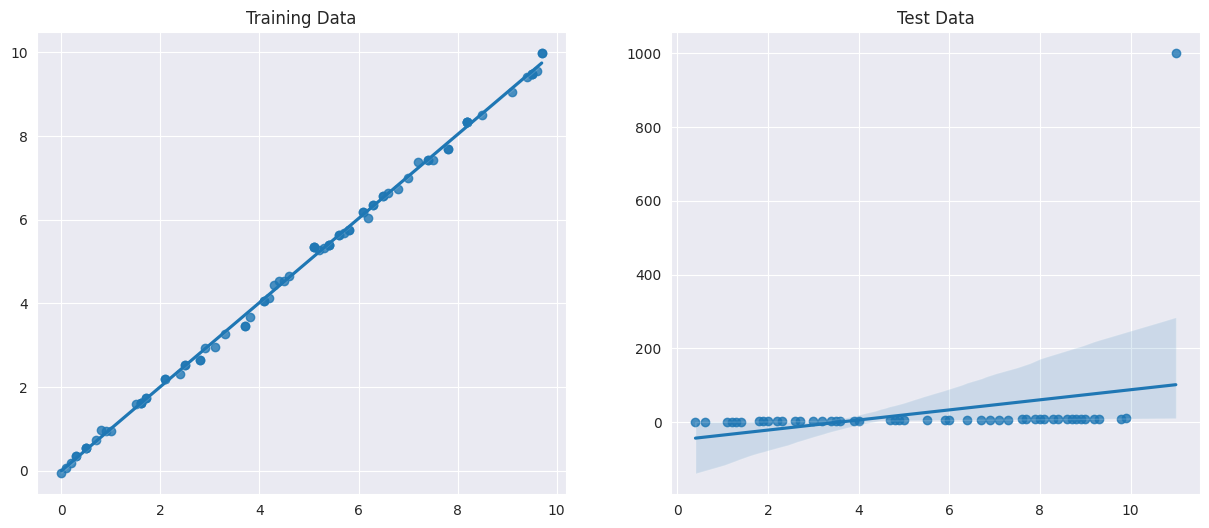

In [39]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(15,6))
sns.regplot(x = x_train, y = y_train, ax = ax[0])
ax[0].set_title('Training Data')
##
sns.regplot(x = x_test, y = y_test, ax = ax[1])
ax[1].set_title('Test Data')
plt.show()

***Respuesta.***

---

In [40]:
model1_pred = x_test
model2_pred = (7.8182)*x_test-24.3557

print('----------------------------------')
print("MAE de model1:", MAE(y_test, model1_pred))
print("MAE de model2:", MAE(y_test, model2_pred))
print('----------------------------------')
print("RMSE de model1:", RMSE(y_test, model1_pred))
print("RMSE de model2:", RMSE(y_test, model2_pred))
print('----------------------------------')
print("MAPE de model1:", MAPE(y_test, model1_pred))
print("MAPE de model2:", MAPE(y_test, model2_pred))
print('----------------------------------')

----------------------------------
MAE de model1: 20.26987875709878
MAE de model2: 38.13719655839178
----------------------------------
RMSE de model1: 141.28575611674023
RMSE de model2: 135.984270646776
----------------------------------
MAPE de model1: 4.589993854029356
MAPE de model2: 513.2308670735728
----------------------------------


¡`MAE` y `MAPE` están a favor del `model1`, mientras que `RMSE` está a favor del `model2`! Observe cómo un único valor atípico puede suponer una amenaza para nuestros modelos. Si eliminamos el valor atípico claro del conjunto de datos, obtenemos:

In [41]:
model1_pred = x_test[:-1]
model2_pred = (7.8182)*x_test[:-1]-24.3557

print('-----------------------------------')
print("MAE de model1:", MAE(model1_pred,y_test[:-1]))
print("MAE de model2:", MAE(model2_pred,y_test[:-1]))
print('-----------------------------------')
print("RMSE de model1:", RMSE(model1_pred,y_test[:-1]))
print("RMSE de model2:", RMSE(model2_pred,y_test[:-1]))
print('-----------------------------------')
print("MAPE de model1:", MAPE(model1_pred,y_test[:-1]))
print("MAPE de model2:", MAPE(model2_pred,y_test[:-1]))
print('-----------------------------------')

-----------------------------------
MAE de model1: 0.0880012312050051
MAE de model2: 19.38264857002494
-----------------------------------
RMSE de model1: 0.10984766638117545
RMSE de model2: 23.086489069725943
-----------------------------------
MAPE de model1: 2.8877672319116567
MAPE de model2: 98.40451080393933
-----------------------------------


Podemos ver claramente que `model1` se ajusta mucho mejor a los datos. Observe cuán robusto fue `MAPE` contra los valores atípicos: los valores no cambiaron mucho aquí.

---

## ***Agregar predictores adicionales para mejorar nuestro modelo.***

---

Considere ahora `model_feat` descrito a continuación. Este modelo agrega características para la cantidad de pisos y dormitorios, el año de construcción, el vecindario (en lugar de simplemente el distrito), el tipo de pared externa, la cantidad de baños completos y medios, el tamaño del lote y el año de venta.

### ***Ejercicio 4:***

---

#### ***4.1***

Ajuste una regresión lineal del logaritmo del precio de venta con las siguientes características:

1. Número de historias (`Stories`).
2. Número de habitaciones (`Bdrms`)
3. Número de unidades en la propiedad (`Units`).
4. Código de barrio (`Nbhd`).
5. Estilo (`Style`).
6. Tipo de pared exterior (`Extwall`).
7. Número de baños completos (`Fbath`).
8. Número de medios baños (`Hbath`).
9. El logaritmo de pies cuadrados. (`log(Fin_sqft)`)
10. El logaritmo del tamaño del lote. (`log(Lotsize)`)
11. Año en que se *construyó* la propiedad como una variable *numérica* (`Year_Built`).
12. Año en que se *vendió* la propiedad como variable *categórica* (`Sale_year`).

Asigne al modelo ajustado resultante el nombre de la variable `model_feat`.



***Respuesta.***

---

In [42]:
model_feat = smf.ols(formula = 'np.log(Sale_price) ~ '
                           'Stories + Year_Built + Nbhd'
                           '+ np.log(Fin_sqft)'
                           '+ Style'
                           '+ Extwall  + Units + Bdrms'
                           '+ Fbath + Hbath + np.log(Lotsize)'
                           '+ C(Sale_year)',
                     data=X_train).fit()
print(model_feat.summary())

                            OLS Regression Results                            
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     447.0
Date:                Fri, 25 Aug 2023   Prob (F-statistic):               0.00
Time:                        02:44:26   Log-Likelihood:                -295.68
No. Observations:               19527   AIC:                             971.4
Df Residuals:                   19337   BIC:                             2468.
Df Model:                         189                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

#### ***4.2***

¿Cómo debe interpretarse el coeficiente `Extwall[T.Brick]` de 0,0218? Seleccione la opción adecuada a continuación:

"Se predice que una propiedad con paredes externas de ladrillo (`Brick`) tendrá un precio de registro que es..."

(a) 0.0218 más alto porcentualmente que una propiedad con paredes externas con  `Aluminum / Vinyl` (aluminio/vinilo) que por lo demás es idéntica.

(b) Aumentado en 0.0218, siendo todo lo demás igual

(c) 0.0218 más alto que la propiedad promedio en el conjunto de datos de entrenamiento.




***Respuesta.***

---

(a) es la interpretación correcta del coeficiente. Los coeficientes categóricos en una regresión lineal siempre se interpretan en relación con la categoría de referencia (si no hay interacción), que por defecto es la primera categoría alfabéticamente, en este caso `Aluminum / Vinyl` (“Aluminio/Vinilo”).

#### ***4.3***

Calcule el `MAE` (Mean Absolute Error) `model_feat` y compárelo con `model_log`. ¿`Model_feat` funciona mejor o peor? ¿Qué pasa con el $R^2$ y el AIC de estos dos modelos?

***Respuesta.***

---

In [43]:
MAE_model_feat = MAE(np.exp(model_feat.predict(X_test)), X_test['Sale_price'])
print('MAE de model_feat: ', MAE_model_feat)
print('R^2 de model_feat:  ', model_feat.rsquared_adj)
print('AIC de model_feat: ', model_feat.aic)

MAE de model_feat:  21686.440973058754
R^2 de model_feat:   0.8119369334709916
AIC de model_feat:  971.3668906221865


In [44]:
MAE_model_log = MAE(np.exp(model_log.predict(X_test)),X_test['Sale_price'])
print('MAE de model_log:', MAE_model_log)
print('R2 de model_log: ', model_log.rsquared_adj)
print('AIC de model_log:', model_log.aic)

MAE de model_log: 31324.029959167085
R2 de model_log:  0.6102744528581773
AIC de model_log: 15030.80159445067


Vemos que el `MAE` y $R^2_{adj}$ de `model_feat` son mucho mejores. ¡Además, el AIC de `model_feat` también ha disminuido! Esto indica que `model_feat` es preferible al modelo `model_log`.



In [45]:
model_feat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     447.0
Date:                Fri, 25 Aug 2023   Prob (F-statistic):               0.00
Time:                        02:44:26   Log-Likelihood:                -295.68
No. Observations:               19527   AIC:                             971.4
Df Residuals:                   19337   BIC:                             2468.
Df Model:                         189                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        1.1031      0.375      2.940      0.003       0.368       1.838
Nbhd[T.1040]                     0.2429      0.036      6.709      0.000       0.172       0.314
Nbhd[T.1140]                    -0.3477      0.036     -9.757      0.000      -0.418      -0.278
Nbhd[T.1150]                    -0.4894      0.041    -11.991      0.000      -0.569      -0.409
Nbhd[T.1160]                    -0.5178      0.044    -11.677      0.000      -0.605      -0.431
Nbhd[T.1200]                    -0.0819      0.044     -1.856      0.064      -0.168       0.005
Nbhd[T.1220]                     0.3823      0.050      7.680      0.000       0.285       0.480
Nbhd[T.1340]                    -0.4104      0.041     -9.949      0.000      -0.491      -0.330
Nbhd[T.1380]                    -0.0260      0.040     -0.654      0.513      -0.104       0.052
Nbhd[T.1400]                     0.0852      0.036      2.369      0.018       0.015       0.156
Nbhd[T.1440]                    -0.5673      0.042    -13.518      0.000      -0.650      -0.485
Nbhd[T.1460]                     0.2530      0.035      7.232      0.000       0.184       0.322
Nbhd[T.1470]                     0.1836      0.036      5.128      0.000       0.113       0.254
Nbhd[T.1480]                     0.0201      0.036      0.557      0.578      -0.051       0.091
Nbhd[T.1490]                     0.0456      0.038      1.207      0.227      -0.028       0.120
Nbhd[T.1500]                    -0.6137      0.049    -12.621      0.000      -0.709      -0.518
Nbhd[T.1560]                    -0.1946      0.051     -3.853      0.000      -0.294      -0.096
Nbhd[T.1620]                    -0.2926      0.041     -7.178      0.000      -0.373      -0.213
Nbhd[T.1680]                    -0.3817      0.042     -9.176      0.000      -0.463      -0.300
Nbhd[T.1740]                    -0.2731      0.043     -6.422      0.000      -0.356      -0.190
Nbhd[T.1780]                    -0.5384      0.047    -11.459      0.000      -0.630      -0.446
Nbhd[T.1820]                    -0.0896      0.043     -2.105      0.035      -0.173      -0.006
Nbhd[T.1830]                     0.0374      0.041      0.910      0.363      -0.043       0.118
Nbhd[T.1840]                     0.1116      0.042      2.686      0.007       0.030       0.193
Nbhd[T.1850]                     0.1567      0.039      4.005      0.000       0.080       0.233
Nbhd[T.1860]                    -0.1732      0.043     -4.068      0.000      -0.257      -0.090
Nbhd[T.1870]                     0.0922      0.045      2.052      0.040       0.004       0.180
Nbhd[T.1880]                    -0.1245      0.093     -1.337      0.181      -0.307       0.058
Nbhd[T.1940]                     0.0772      0.039      1.984      0.047    

#### ***4.4***


¿Qué historia nos cuenta este modelo sobre el mercado inmobiliario de Milwaukee durante los últimos 15 años?

(a) Los precios aumentaron hasta 2007, cuando hubo un colapso inmobiliario. Desde entonces, los precios han vuelto a subir a su nivel anterior al colapso.

(b) En general, los precios de la vivienda aumentaron constantemente a lo largo del tiempo

(c) Los precios aumentaron hasta 2007, luego bajaron posteriormente

(d) Los precios aumentaron hasta 2007, cuando hubo un colapso inmobiliario. Desde entonces, los precios han subido lentamente, pero aún no se han recuperado por completo.

***Respuesta.***

---

(d). El coeficiente para 2018 sigue siendo más bajo que el de 2006. Esto también se puede ver en la gráfica de coeficientes a continuación:

**Answer.** (d). The coefficient for 2018 is still lower than 2006 and 2008. This can also be seen from the plot of coefficients below:

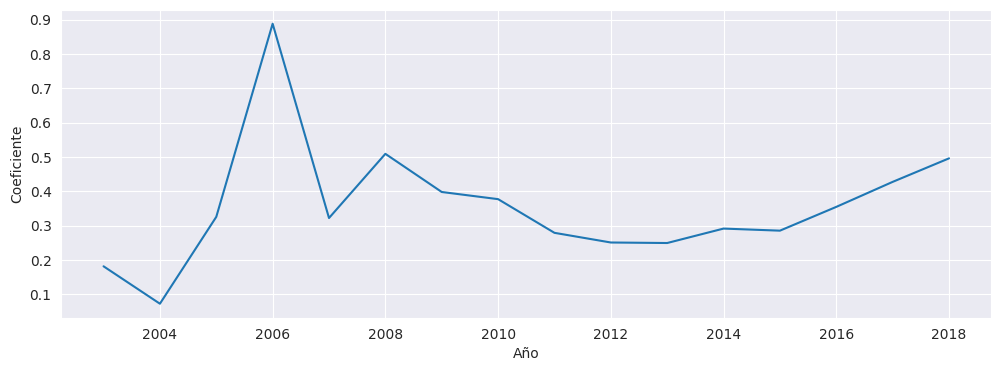

In [46]:
year = range(2003,2019)
year_coef = model_feat.params['C(Sale_year)[T.2003]':'C(Sale_year)[T.2018]']
plt.figure(figsize = (12,4))
plt.plot(year, year_coef)
plt.xlabel('Año')
plt.ylabel('Coeficiente')
plt.show()

#### ***4.5***

Se vende una residencia `townhouse` de 2 pisos (`Stories`) en $150,000 con las siguientes características:

1. Barrio 4320 en el Distrito 11.
2. 1200 pies cuadrados terminados.
3. Tamaño del lote de 7200 pies cuadrados.
4. 3 dormitorios.
5. Pared exterior de vinilo (`Vinyl`).
6. construido en 1987
7. 1 baño completo y 1 medio baño
8. 1 unidad.

¿Es este un buen precio según nuestro modelo? ¿Qué suposiciones tienes que hacer para responder a esta pregunta?




***Respuesta.***

---

Nuestro modelo predice (ver abajo) que esta casa debería venderse por alrededor de $\$130,000$. Por lo tanto, $\$150,000$ es un precio demasiado alto a menos que la casa tenga características positivas que no se capturen en los datos.

Un factor que no tomamos en cuenta es que la venta tuvo lugar en 2019. Como no tenemos datos de 2019, tuvimos que asumir que los precios se mantuvieron estables después de 2018. Es posible que los precios de los bienes raíces hayan subido significativamente en 2019, lo que podría justificar el precio inicial de $\$150,000.$



In [47]:
d = {'Stories': 2,
     'Style': 'Townhouse',
     'Extwall': 'Aluminum / Vinyl',
     'Nbhd': '4320',
     'Fin_sqft': 1200.0,
     'Lotsize': 7200.0,
     'Sale_year': 2018,                   # no hay datos de entrenamiento para 2019,
                                          # por lo que debemos suponer que los precios se mantuvieron
                                          # estables desde el 2018.
     'Year_Built':  1987,
     'Fbath': 1,
     'Hbath': 1,
     'Units': 1,
     'Bdrms': 3}
d_df = X_test.copy()
d_df = d_df.append(d, ignore_index=True)
pred = model_feat.predict(d_df.iloc[-1:]).iloc[0]
print('Vía el modelo se pronostica que esta propiedad se venda por: ${:,.0f}.'.format(np.exp(pred)))

Vía el modelo se pronostica que esta propiedad se venda por: $129,054.


In [48]:
np.exp(pred)

129054.43639512078

In [49]:
d_df

,District,Nbhd,Style,Extwall,Stories,Year_Built,Nr_of_rms,Fin_sqft,Units,Bdrms,Fbath,Hbath,Lotsize,Sale_price,Sale_year
0,5,2100,Cape Cod,Brick,1.5,1937,0.0,1392.0,1,3,1,1,6000.0,175000.0,2011
1,13,4620,Milwaukee Bungalow,Aluminum / Vinyl,1.0,1928,0.0,1341.0,1,4,1,1,5460.0,200000.0,2014
2,9,480,Ranch,Aluminum / Vinyl,1.0,1958,0.0,998.0,1,3,2,0,7913.0,98000.0,2016
3,9,480,Ranch,Brick,1.0,1959,0.0,1126.0,1,3,2,0,10296.0,146500.0,2018
4,14,4510,Residence O/S,Aluminum / Vinyl,1.0,1900,0.0,1220.0,1,3,2,0,4290.0,170000.0,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4879,14,4580,Cape Cod,Stucco,1.0,1944,0.0,1198.0,1,3,2,0,5040.0,175000.0,2016
4880,14,4520,Duplex O/S,Brick,1.5,1938,0.0,2039.0,2,4,2,2,4620.0,170000.0,2018
4881,11,4240,Cape Cod,Brick,1.0,1955,0.0,1390.0,1,4,1,0,4944.0,110000.0,2013
4882,8,4120,Duplex O/S,Frame,2.0,1910,0.0,2244.0,2,6,2,0,4158.0,87000.0,2017


In [50]:
d_df

,District,Nbhd,Style,Extwall,Stories,Year_Built,Nr_of_rms,Fin_sqft,Units,Bdrms,Fbath,Hbath,Lotsize,Sale_price,Sale_year
0,5,2100,Cape Cod,Brick,1.5,1937,0.0,1392.0,1,3,1,1,6000.0,175000.0,2011
1,13,4620,Milwaukee Bungalow,Aluminum / Vinyl,1.0,1928,0.0,1341.0,1,4,1,1,5460.0,200000.0,2014
2,9,480,Ranch,Aluminum / Vinyl,1.0,1958,0.0,998.0,1,3,2,0,7913.0,98000.0,2016
3,9,480,Ranch,Brick,1.0,1959,0.0,1126.0,1,3,2,0,10296.0,146500.0,2018
4,14,4510,Residence O/S,Aluminum / Vinyl,1.0,1900,0.0,1220.0,1,3,2,0,4290.0,170000.0,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4879,14,4580,Cape Cod,Stucco,1.0,1944,0.0,1198.0,1,3,2,0,5040.0,175000.0,2016
4880,14,4520,Duplex O/S,Brick,1.5,1938,0.0,2039.0,2,4,2,2,4620.0,170000.0,2018
4881,11,4240,Cape Cod,Brick,1.0,1955,0.0,1390.0,1,4,1,0,4944.0,110000.0,2013
4882,8,4120,Duplex O/S,Frame,2.0,1910,0.0,2244.0,2,6,2,0,4158.0,87000.0,2017


---

## ***Colinealidad y errores estándar.***

---

El modelo de la sección anterior parece ser un buen paso hacia nuestro objetivo principal.En las últimas lecturas se aprendió que agregar una gran cantidad de nuevas varibales a un modelo y luego dejarlo así,no es una estrategia prudente, pues:

1. No queremos incluir características que agreguen poco poder predictivo a nuestro modelo. De lo contrario, podemos terminar con un modelo demasiado complicado. Recuerde que generalmente queremos un modelo que logre un buen nivel de predictividad sin sacrificar la simplicidad.

2. Agregar demasiadas características aumenta el peligro de *overfitting*, lo que disminuye la aplicabilidad potencial del modelo.

Hemos aprendido un par de métodos para aliviar estos problemas:

1. Podemos utilizar indicadores como el `AIC` para detectar si estamos sumando variables con poco poder predictivo.

2. Podemos dividir nuestros datos de muestra en conjuntos `Train/Test` y usar el conjunto `Test`, junto con alguna medida como `RMSE`, para evaluar la aplicabilidad de nuestro modelo.

Sin embargo, existe un tercer problema potencial cada vez que agregamos demasiadas características a nuestros modelos:

3. La regresión lineal en realidad puede **desestabilizarse** cuando hay demasiados predictores que no agregan valor.

Esto significa que pequeños cambios en los datos de entrenamiento introducidos en el modelo dan como resultado grandes cambios en los coeficientes ajustados; el sobreajuste es una consecuencia común de este fenómeno.

### ***Pregunta:***

¿Qué crees que hace que suceda en lo anterior?

A medida que se agregan más predictores, comienzan a contribuir con información redundante (lo que explica por qué cada predictor adicional aporta información marginal cero). Matemáticamente, esto significa que los nuevos predictores a menudo se pueden expresar en buena medida como combinaciones lineales de algunos de los otros predictores. Cuando esto sucede, se dice que un modelo exhibe **colinealidad** o **multicolinealidad**. Para una posible solución puede explorar https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Dado que los predictores se vuelven en su mayoría redundantes, esto significa que se pueden obtener predicciones casi idénticas con valores de coeficientes muy diferentes, mediante el "intercambio" entre los coeficientes de los predictores que exhiben colinealidad.
En consecuencia, el modelo no tiene forma de decidir solo a partir de los datos cuál de estos posibles modelos con predicciones idénticas elegir, lo que se traduce en errores estándar inflados y un alto riesgo de ***overfitting***.

Para demostrar este efecto, introduciomos la varible.
La pequeña constante está ahí para evitar que la nueva función sea *perfectamente* colineal con log(`Fin_sqft`) y log(`Lotsize`) (lo que crearía un error de "dividir por cero" en el código de la función de regresión en segundo plano):




In [51]:
# modelo base sin característica colineal diseñada
model_finlot = smf.ols(formula = 'np.log(Sale_price) ~ '
                           'Stories + Year_Built'
                           '+ np.log(Fin_sqft)'
                           '+ np.log(Lotsize)'
                           '+ C(Style)'
                           '+ Extwall  + Units + Bdrms'
                           '+ Fbath + Hbath + C(Nbhd)'
                           '+ C(Sale_year)',
                 data = X_train).fit()
print(model_finlot.summary())

                            OLS Regression Results                            
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     447.0
Date:                Fri, 25 Aug 2023   Prob (F-statistic):               0.00
Time:                        02:44:27   Log-Likelihood:                -295.68
No. Observations:               19527   AIC:                             971.4
Df Residuals:                   19337   BIC:                             2468.
Df Model:                         189                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [52]:
model_coll = smf.ols(formula = 'np.log(Sale_price) ~ '
                           'Stories + Year_Built'
                           '+ np.log(Fin_sqft)'
                           '+ np.log(Lotsize)'
                           '+ np.log(Fin_sqft/Lotsize + 0.0001)'
                           '+ Style'
                           '+ Extwall  + Units + Bdrms'
                           '+ Fbath + Hbath'
                           '+ C(Nbhd)'
                           '+ C(Sale_year)',
                 data = X_train).fit()
print(model_coll.summary())

                            OLS Regression Results                            
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     444.9
Date:                Fri, 25 Aug 2023   Prob (F-statistic):               0.00
Time:                        02:44:28   Log-Likelihood:                -291.89
No. Observations:               19527   AIC:                             965.8
Df Residuals:                   19336   BIC:                             2471.
Df Model:                         190                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

# Modelo sobreajustado

In [55]:
len(X_train['Nbhd'].unique())*len(X_train['Style'].unique())*len(X_train['Extwall'].unique())

25380

In [63]:
model_sobreajustado = smf.ols(formula = 'Sale_price ~ '
                           'Stories + Fin_sqft**3*Year_Built'
                           ' + Fin_sqft**3*Nbhd'
                           '+ Style*Extwall*Hbath*Fbath*Units*Bdrms*Year_Built'
                           #'+ Style*Extwall*Hbath*Fbath*Units*Bdrms*Nbhd'
                           ,
                     data=X_train).fit()
print(model_sobreajustado.rsquared)

0.8889927263185897


In [64]:
#model_sobreajustado.summary()

In [65]:
print(MAE((model_sobreajustado.predict(X_test)), X_test['Sale_price']))
print(MAE((model_sobreajustado.predict(X_train)), X_train['Sale_price']))

51494.213023451775
19992.751961717182


In [66]:
print(RMSE((model_sobreajustado.predict(X_test)), X_test['Sale_price']))
print(RMSE((model_sobreajustado.predict(X_train)), X_train['Sale_price']))

764577.8649422704
28060.782380642657


### ***Ejecicio 5.***

---

#### ***5.1***

¿Qué sucedió con los coeficientes y los errores estándar de `log(Fin_sqft)` y `log(Lotsize)` cuando se introdujo la varible construida?

***Respuesta.***

---

El coeficiente de `log(Fin_sqft)` aumentó en un gran número, mientras que el coeficiente de `log(Lotsize)` disminuyó en un número igualmente grande. El coeficiente de `log(Lotsize)` ahora es un número *negativo* absurdamente grande. Los coeficientes están desestabilizados, lo que se refleja en errores estándar mucho más altos (que pasaron de alrededor de 0,01 a 18).

#### ***5.2.***

¿Qué sucede cuando cambia la constante 0,0001 (por ejemplo, a 0,00001 o 0,001) en la variable construida?

***Respuesta.***

---

A medida que crece la constante, la colinealidad se debilita.



Para detectar e investigar las colinealidades, es útil observar las correlaciones entre los predictores dentro de un modelo, como se muestra a continuación. Observe las altas correlaciones (positivas *o* negativas) entre la función de ingeniería `np.log(Fin_sqft / Lotsize + 0.0001)` y `np.log(Fin_sqft)`/`np.log(Lotsize)`. Tenga en cuenta también las otras correlaciones altas con baños y número de pisos en la matriz. Estos pueden desestabilizar el modelo y dificultar la formulación de afirmaciones significativas sobre el valor incremental de agregar baños e historias adicionales.

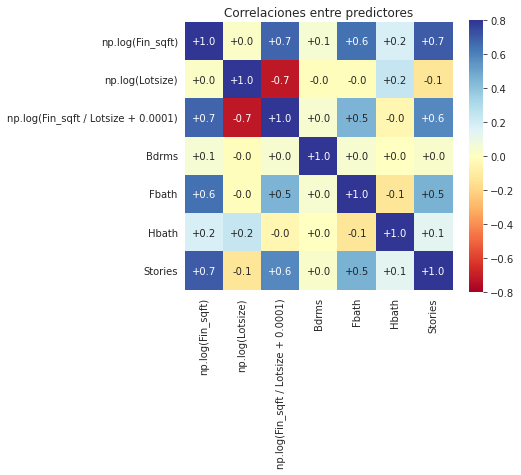

In [ ]:
M = model_coll.model.data.exog # La matriz de diseño X  con
                               # predictores que incluyen variables "dummys"
                               # para las variables categóricas.
param_names = model_coll.model.data.param_names # Nombre de los parámetros.
M_df = pd.DataFrame(M, columns=param_names) # Pandas DataFrame
# Subconjunto de predictores para graficar:
M_sub=M_df[['np.log(Fin_sqft)','np.log(Lotsize)',
              'np.log(Fin_sqft / Lotsize + 0.0001)',
              'Bdrms','Fbath','Hbath','Stories']]
plt.figure(figsize=(6,5))
sns.heatmap(M_sub.corr(), cmap="RdYlBu",annot=True, square=True, vmin=-0.8, vmax=0.8, fmt="+.1f")
plt.title("Correlaciones entre predictores")
plt.show()

Esto ilustra el peligro de simplemente incluir características adicionales en un modelo. No solo es redundante, sino que también puede conducir a valores altamente inestables y sin sentido para los coeficientes, lo que puede conducir a un sobreajuste en los sistemas de producción. Una forma de lidiar con esto es lo que discutimos en casos anteriores: usar el criterio AIC para evaluar iterativamente cada característica nueva y determinar si realmente agrega suficiente valor incremental además de una penalización por la complejidad adicional. Otra es examinar matrices de correlación como la que creamos anteriormente para identificar cualquier valor cercano a -1 o 1. Con técnicas como ***cross-validation*** y la ***regularización*** se pueden tener formas adicionales de lidiar con modelos complejos y potencialmente sobreajustados.

---

## ***Conclusiones.***

---

En esta lectura vimos más de cerca a los predictores categóricos. Luego nos enfocamos en las predicciones y discutimos algunas métricas diferentes para el poder predictivo de un modelo de regresión. Cada uno tenía sus propias ventajas y desventajas dependiendo de lo que el problema comercial en cuestión necesitaba priorizar.

Vimos que agregar tantas características a la vez podría generar **colinealidad** y, por lo tanto, desestabilizar un modelo, dificultando la interpretación de los coeficientes y aumentando la posibilidad de predicciones sobreajustadas (***overfitting***) en la producción.

---

## ***Comentarios.***

---

En esta lectura hemos ampliado nuestra caja de herramientas para el diagnóstico de modelos de regresión lineal. Hemos aprendido:
    
1. Cómo el uso de conjuntos de entrenamiento/prueba, junto con medidas como MAE, MAPE y RMSE pueden ayudar a evaluar el poder predictivo de los modelos lineales. Se observa que estas herramientas no solo son aplicables a modelos lineales, sino que también funcionan con cualquier otro tipo de modelo.

2. Cómo se codifican las variables categóricas en los modelos de regresión lineal.

3. Que los modelos más complejos pueden proporcionar mejores predicciones, pero esto puede desestabilizar el rendimiento. En muchas de estas situaciones, la complejidad crea multicolinealidad entre las variables, lo que en realidad hace que nuestros modelos sean muy inestables y propensos al sobreajuste.

Recuerde, gran parte del mundo de los negocios se trata de aplicar modelos entrenados en datos futuros, actualmente desconocidos. El sobreajuste puede generar impactos negativos graves en el resultado final.



---

<font color = red FONT SIZE = 5>***Créditos***</font>

---

"Property sales data, 2002-2018 Master File",2020, Milwaukee OpenData, Creative Commons Attribution, https://data.milwaukee.gov/dataset/property-sales-data/resource/f083631f-e34e-4ad6-aba1-d6d7dd265170